# Simon's world Cup 2018 Playground

This is the playground of mine to play with world cup 2018's data. The data is based on [this free API](http://worldcup.sfg.io/). This notebook is the testfield and lab where I can play, explore and learn from this project of mine, so please bear with me if it's too messy.

<img src="./statics/227px-2018_FIFA_World_Cup.svg.png">

# NOTES

### NOTES to title markdown cell above

[ref/doc link](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html)

1. Way to add Hyperlink
    ```
    [shown word](url)
    ```
2. Add image to the cell
    ```
    <img src="./statics/227px-2018_FIFA_World_Cup.svg.png">
    ```
    
### NOTES to ipwidgets
[ipwidgets doc](http://ipywidgets.readthedocs.io/en/latest/index.html)

##### 1. ipwidgets.Output
[see this doc](http://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html)
* the way to add strings to show
    ```python
    out = ipwidgets.Output()
    with out:
        print("hello world")
    display(out)
    ```
* the way to clear the Output
    ```python
    out.clear_output()
    ```

##### 2. ipwidgets.Image
[see this doc](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html?#Image)

* The file must be open in 'b' mode
    ```python
    f_image = open("image.png", 'rb')
    ```

##### 3. ipwidgets.interact and ipwidgets.interactive
[see this doc](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)

**interact** directly display the widgets, while **interactive** returns a widgets which is not displayed directly.

##### 4. use ipwidgets.VBox and ipwidgets.HBox to allign widgets (they work as containers)

### NOTES to matplotlib
[matplotlib doc](https://matplotlib.org/)

##### 1. Bar Chart

[doc](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.bar.html?highlight=bar#matplotlib.axes.Axes.bar)

see also:

https://matplotlib.org/gallery/statistics/barchart_demo.html#sphx-glr-gallery-statistics-barchart-demo-py

https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py


In [3]:
import json
import urllib.request

group_dict = {}
team_dict = {}
match_dict = {}

# classes of the project

### group

In [4]:
class wc_group(object):
    def __init__(self, group_id, letter, teams):
        self.group_id = group_id
        self.letter = letter
        self.teams = teams
        
    def __repr__(self):
        return "Group: " + self.letter
    
    def teamInGroup(self):
        for team in self.teams.values():
            yield team

### team

In [5]:
class wc_team(object):

    def __init__(self, team_id, country, fifa_code, wins, draws, losses, games_played, points, goals_for, goals_against, goal_differential):
        self.team_match_dict = {}
        self.team_completed_match_dict = {}
        self.team_win_match_dict = {}
        self.team_draw_match_dict = {}
        self.team_loss_match_dict = {}
        self.match_id_opponent_dict = {}
        self.team_id = team_id
        self.country = country
        self.fifa_code = fifa_code
        self.wins = wins
        self.draws = draws
        self.losses = losses
        self.games_played = games_played
        self.points = points
        self.goals_for = goals_for
        self.goals_against = goals_against
        self.goal_differential = goal_differential
        
        
    def __repr__(self):
        return self.country + "(" + self.fifa_code + ") Wins:" + str(self.wins) + " Draws:" + str(self.draws) +\
               " Losses:" + str(self.losses) + " Games played:" + str(self.games_played) + " Points:" + str(self.points) +\
               " Goals for:" + str(self.goals_for) + " Goals against:" + str(self.goals_against) + " Goal differential:" +\
               str(self.goal_differential)
                
    def classifyPlayedMatchesByResults(self):
        for m in self.team_completed_match_dict.values():
            if m.getWinner() == "Draw":
                self.team_draw_match_dict[m.getMatchId()] = m
            elif m.getWinner() == self:
                self.team_win_match_dict[m.getMatchId()] = m
            else:
                self.team_loss_match_dict[m.getMatchId()] = m
                        
    def fetchDetailedMatchInfo(self):
        # this function will add all detailed info of all matches of this team
        matches_json = urllib.request.urlopen('http://worldcup.sfg.io/matches/country?fifa_code=' + self.fifa_code)
        matches_python = json.loads(matches_json.read())
        
        for m in matches_python:
            if not m['fifa_id'] in match_dict:
                match_dict[m['fifa_id']] = wc_match(location = m['venue'], venue = m['location'],
                                                    status = m['status'], time = m['time'],
                                                    fifa_id = m['fifa_id'], datetime = m['datetime'],
                                                    home_team = team_dict[m['home_team']['country']],
                                                    away_team = team_dict[m['away_team']['country']],
                                                    home_team_goals = m['home_team']['goals'],
                                                    away_team_goals = m['away_team']['goals'],
                                                    home_team_statistics = m['home_team_statistics'],
                                                    away_team_statistics = m['away_team_statistics'],
                                                    home_event_list = m['home_team_events'],
                                                    away_event_list = m['away_team_events'], winner = m['winner_code'])
            if not m['fifa_id'] in self.match_id_opponent_dict:
                if m['home_team']['country'] == self.country:
                    self.match_id_opponent_dict[m['fifa_id']] = team_dict[m['away_team']['country']]
                else:
                    self.match_id_opponent_dict[m['fifa_id']] = team_dict[m['home_team']['country']]
                    
            if not m['fifa_id'] in self.team_match_dict:
                self.team_match_dict[m['fifa_id']] = match_dict[m['fifa_id']]
            if match_dict[m['fifa_id']].isCompleted():
                if not m['fifa_id'] in self.team_completed_match_dict:
                    self.team_completed_match_dict[m['fifa_id']] = match_dict[m['fifa_id']]
            
        
        matches_json.close()
        
        self.classifyPlayedMatchesByResults()
        
    def addMatch(self, m):
        if not m.getMatchId() in self.team_match_dict:
            self.team_match_dict[m.getMatchId()] = m
        if m.isCompleted() and (not m.getMatchId() in self.team_completed_match_dict):
            self.team_completed_match_dict[m.getMatchId()] = m
        if not m.getMatchId() in self.match_id_opponent_dict:
            if m.getHomeTeam()==self:
                self.match_id_opponent_dict[m.getMatchId()] = m.getAwayTeam()
            else:
                self.match_id_opponent_dict[m.getMatchId()] = m.getHomeTeam()
            
        
    
    def getFifaCode(self):
        return self.fifa_code
    
    def getCountryName(self):
        return self.country
    
    def getCountryNameWithCode(self):
        return self.country + "(" + self.fifa_code + ")"
    
    def generateCompletedMatches(self):
        for match in self.team_completed_match_dict.values():
            yield match
            
    def getMatchDictByOpponent(self):
        d = {}
        for m in self.team_match_dict.values():
            if m.getHomeTeam() == self:
                d["v.s. " + m.getAwayTeam().getCountryName() + "   [" + m.getMatchId() + "]"] = m
            else:
                d["v.s. " + m.getHomeTeam().getCountryName() + "   [" + m.getMatchId() + "]"] = m
        return d      

### match

In [6]:
class wc_match(object):
    def __init__(self, location, venue, status , time, fifa_id, datetime ,
                 home_team_goals, away_team_goals,
                 home_team_statistics, away_team_statistics,
                 home_team, away_team, home_event_list, away_event_list, winner):
        self.location = location
        self.venue = venue
        self.status = status
        self.time = time
        self.fifa_id = fifa_id
        self.datetime = datetime
        self.home_team_goals = home_team_goals
        self.away_team_goals = away_team_goals
        self.home_team_statistics = home_team_statistics
        self.away_team_statistics = away_team_statistics
        self.home_team = home_team
        self.away_team = away_team
        self.home_event_list = home_event_list
        for d in self.home_event_list:
            d['team'] = home_team
        self.away_event_list = away_event_list
        for d in self.away_event_list:
            d['team'] = away_team
        if self.status=='completed':
            if winner != 'Draw':
                self.winner = self.home_team if self.home_team.getFifaCode() == winner else self.away_team
            else:
                self.winner = "Draw"
            self._buildOrderedEventList()
        else:
            self.ordered_event_list = []
            self.winner = ""
        
    def __repr__(self):
        return "Match " + self.fifa_id + ": " + self.home_team.getCountryNameWithCode() + " v.s. " +\
               self.away_team.getCountryNameWithCode() + " on " + self.datetime + " in " + self.venue
        
    def _buildOrderedEventList(self):
        from operator import itemgetter
        e_list = self.home_event_list + self.away_event_list
        self.ordered_event_list = sorted(e_list, key=itemgetter("time","id"))
    
    def getMatchId(self):
        return self.fifa_id
    
    def isCompleted(self):
        return True if self.status == 'completed' else False
    
    def getWinner(self):
        return self.winner
    
    def getHomeTeam(self):
        return self.home_team
    
    def getAwayTeam(self):
        return self.away_team
    
    def printBasicMatchInfo(self):
        print("Venue:          " + self.venue + ", " + self.location)
        print("Date Time:      " + self.datetime)
        if len(self.home_team.getCountryNameWithCode())<15:
            blank = ' '*(16 - len(self.home_team.getCountryNameWithCode()))
        else:
            blank = ' '*2
        print(self.home_team.getCountryNameWithCode() + blank + "v.s." + blank + self.away_team.getCountryNameWithCode())
        if self.status == 'completed':
            print(' '*8 + str(self.home_team_goals) + 8*' ' + '--' + 8*' ' + str(self.away_team_goals)) 
            if self.winner != 'Draw':             
                print(self.winner.getCountryNameWithCode() + " wins!")
            else:
                print("Draw Game!")
        else:
            print("Game is not yet finished!")
    
    def printMatchEvents(self):
        print("Events:")
        for d in self.ordered_event_list:
            print(d)
            
    def getOrderedEventsList(self):
        return self.ordered_event_list

### build the dict of group and the dict of team

In [7]:
group_results_json = urllib.request.urlopen('http://worldcup.sfg.io/teams/group_results')
group_results_python = json.loads(group_results_json.read())

for group in group_results_python:
    team_dict_in_group = {}
    for team in group['group']['teams']:
        team_dict_in_group[team['team']['country']] = wc_team(team['team']['id'], team['team']['country'], team['team']['fifa_code'],
                                                              team['team']['wins'], team['team']['draws'], team['team']['losses'],
                                                              team['team']['games_played'], team['team']['points'], team['team']['goals_for'],
                                                              team['team']['goals_against'], team['team']['goal_differential'])
        team_dict[team['team']['country']] = team_dict_in_group[team['team']['country']]
    group_dict[group['group']['letter']] = wc_group(group['group']['id'], group['group']['letter'], team_dict_in_group)

In [20]:
# print them
for g in group_dict.values():
    print(g)
    for t in g.teamInGroup():
        print(t)

Group: A
Russia(RUS) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:8 Goals against:1 Goal differential:7
Uruguay(URU) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:2 Goals against:0 Goal differential:2
Egypt(EGY) Wins:0 Draws:0 Losses:2 Games played:2 Points:0 Goals for:1 Goals against:4 Goal differential:-3
Saudi Arabia(KSA) Wins:0 Draws:0 Losses:2 Games played:2 Points:0 Goals for:0 Goals against:6 Goal differential:-6
Group: B
Spain(ESP) Wins:1 Draws:1 Losses:0 Games played:2 Points:4 Goals for:4 Goals against:3 Goal differential:1
Portugal(POR) Wins:1 Draws:1 Losses:0 Games played:2 Points:4 Goals for:4 Goals against:3 Goal differential:1
Iran(IRN) Wins:1 Draws:0 Losses:1 Games played:2 Points:3 Goals for:1 Goals against:1 Goal differential:0
Morocco(MAR) Wins:0 Draws:0 Losses:2 Games played:2 Points:0 Goals for:0 Goals against:2 Goal differential:-2
Group: C
France(FRA) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:3 Goals against:1 Goal differe

### build all matches in group A

In [21]:
for t in group_dict['A'].teamInGroup():
    t.fetchDetailedMatchInfo()

### build all matches in group B

In [22]:
for t in group_dict['B'].teamInGroup():
    t.fetchDetailedMatchInfo()

### print all completed matches of Russia in Group A

In [23]:
for m in team_dict['Russia'].generateCompletedMatches():
    print(m)
    m.printBasicMatchInfo()
    m.printMatchEvents()

Match 300331503: Russia(RUS) v.s. Saudi Arabia(KSA) on 2018-06-14T15:00:00Z in Luzhniki Stadium
Venue:          Luzhniki Stadium, Moscow
Date Time:      2018-06-14T15:00:00Z
Russia(RUS)     v.s.     Saudi Arabia(KSA)
        5        --        0
Russia(RUS) wins!
Events:
{'id': 5, 'type_of_event': 'goal', 'player': 'Iury GAZINSKY', 'time': "12'", 'team': Russia(RUS) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:8 Goals against:1 Goal differential:7}
{'id': 1, 'type_of_event': 'substitution-in', 'player': 'Denis CHERYSHEV', 'time': "24'", 'team': Russia(RUS) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:8 Goals against:1 Goal differential:7}
{'id': 320, 'type_of_event': 'substitution-out', 'player': 'Alan DZAGOEV', 'time': "24'", 'team': Russia(RUS) Wins:2 Draws:0 Losses:0 Games played:2 Points:6 Goals for:8 Goals against:1 Goal differential:7}
{'id': 2, 'type_of_event': 'goal', 'player': 'Denis CHERYSHEV', 'time': "43'", 'team': Russia(RUS) Wins:2 Draws:0 Losses

### add all matches

In [8]:
all_matches_json = urllib.request.urlopen('http://worldcup.sfg.io/matches')
all_matches_python = json.loads(all_matches_json.read())

for m in all_matches_python:
    if not m['fifa_id'] in match_dict:
        if (m['home_team']['country'] != "To Be Determined") and (m['away_team']['country'] != "To Be Determined"):
            match_dict[m['fifa_id']] = wc_match(location = m['venue'], venue = m['location'],
                                                status = m['status'], time = m['time'],
                                                fifa_id = m['fifa_id'], datetime = m['datetime'],
                                                home_team = team_dict[m['home_team']['country']],
                                                away_team = team_dict[m['away_team']['country']],
                                                home_team_goals = m['home_team']['goals'],
                                                away_team_goals = m['away_team']['goals'],
                                                home_team_statistics = m['home_team_statistics'],
                                                away_team_statistics = m['away_team_statistics'],
                                                home_event_list = m['home_team_events'],
                                                away_event_list = m['away_team_events'], winner = m['winner_code'])
            team_dict[m['home_team']['country']].addMatch(match_dict[m['fifa_id']])
            team_dict[m['away_team']['country']].addMatch(match_dict[m['fifa_id']])
            
    

## interactive with *ipwidgets*

In [9]:
import ipywidgets as widgets
out = widgets.Output()
match_info_out = widgets.Output(layout={'border': '1px solid black'})


def showMatchInfo(x):
    match_info_out.clear_output()
    with match_info_out:
        x.printBasicMatchInfo()
    display(match_info_out)
    button_show_events = widgets.Button(description="Show Events")
    button_home_statistics = widgets.Button(description = x.getHomeTeam().getCountryName() + " statistics")
    button_away_statistics = widgets.Button(description = x.getAwayTeam().getCountryName() + " statistics")
    f_flag_home = open("./statics/Flag_of_" + x.getHomeTeam().getCountryName() + ".svg.png", 'rb').read()
    f_flag_away = open("./statics/Flag_of_" + x.getAwayTeam().getCountryName() + ".svg.png", 'rb').read()
    flag_home = widgets.Image(value=f_flag_home, format='png', width=45, height=9)
    flag_away = widgets.Image(value=f_flag_away, format='png', width=45, height=9)
    bout=widgets.Output()
    def buttonShowEventsOnClick(b):
        bout.clear_output()
        with bout:
            for e in x.getOrderedEventsList():
                if e["type_of_event"] in ['yellow-card', 'red-card', 'substitution-in', 'substitution-out']:
                    f_event_type = open("./statics/" + e["type_of_event"] + ".svg.png", 'rb').read()
                    event_type = widgets.Image(value=f_event_type, format='png', width=12, height=24)
                elif e['type_of_event'] in ['goal-own','goal-penalty', 'goal']:
                    goal_type_out = widgets.Output(layout={'border': '1px solid red'})
                    with goal_type_out:
                        if e['type_of_event'] == 'goal-own':
                            print("o.g.")
                        elif e['type_of_event'] == 'goal-penalty':
                            print("pen.")
                    f_event_type = open("./statics/goal.svg.png", 'rb').read()
                    if e['type_of_event'] == 'goal':
                        event_type = widgets.Image(value=f_event_type, format='png', width=24, height=24)
                    else:
                        event_type = widgets.HBox([widgets.Image(value=f_event_type, format='png', width=24, height=24), goal_type_out])
                else:
                    event_type = widgets.Output(layout={'border': '1px solid black'})
                    with event_type:
                        print(e["type_of_event"])
                event_time = widgets.Output(layout={'border': '3px solid black'})
                with event_time:
                    print(e['time'])
                event_player = widgets.Output()
                with event_player:
                    print(e['player'])
                event_flag = flag_home if e['team']==x.getHomeTeam() else flag_away
                event_info_box = widgets.HBox([event_time, event_type, event_player, event_flag])
                display(event_info_box)
                
    def buttonShowHomeStatisticsOnClick(b):
        bout.clear_output()
        with bout:
            for k, v in x.home_team_statistics.items():
                print(k + " " + str(v))
    def buttonShowAwayStatisticsOnClick(b):
        bout.clear_output()
        with bout:
            for k, v in x.away_team_statistics.items():
                print(k + " " + str(v))
    button_show_events.on_click(buttonShowEventsOnClick)
    button_home_statistics.on_click(buttonShowHomeStatisticsOnClick)
    button_away_statistics.on_click(buttonShowAwayStatisticsOnClick)
    if x.isCompleted():
        #display(button_show_events)
        #display(button_home_statistics)
        #display(button_away_statistics)
        #display(bout)
        buttons_results_box = widgets.VBox([widgets.HBox([button_show_events, button_home_statistics, button_away_statistics]), bout])
        display(buttons_results_box)

def showTeamInfo(x):
    out.clear_output()
    with out:
        print(x)
    fi = open("./statics/Flag_of_" + x.getCountryName() + ".svg.png", 'rb')
    image = fi.read()
    team_flag = widgets.Image(value=image, format='png', width=36, height=6)
    team_info_box = widgets.HBox([team_flag, out])
    display(team_info_box)
    if x.team_match_dict:
        choose_match_dropdown = widgets.interactive(showMatchInfo, x=widgets.Dropdown(description="Match",
                                                                                         options=x.getMatchDictByOpponent()))
        display(choose_match_dropdown)
        widgets.VBox([choose_team_dropdown, team_info_box, choose_match_dropdown, match_info_out])
        


choose_team_dropdown = widgets.interactive(showTeamInfo, x =widgets.Dropdown(description="Team", options=team_dict))
display(choose_team_dropdown)

A Jupyter Widget

## try visualization with matplotlib

#### bar chart

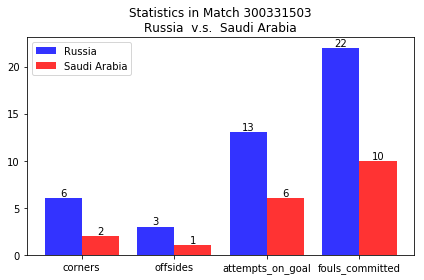

In [15]:
import numpy as np
import matplotlib.pyplot as plt
m = match_dict['300331503']

wanted_keys = ['corners', 'offsides', 'attempts_on_goal', 'fouls_committed']
n_groups = len(wanted_keys)
home_team_shown_data = []
away_team_shown_data = []
for k in wanted_keys:
    home_team_shown_data.append(m.home_team_statistics[k])
    away_team_shown_data.append(m.away_team_statistics[k])

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = ax.bar(index, home_team_shown_data, bar_width,
                alpha=opacity, color='b',
                label=m.home_team_statistics['country'])

rects2 = ax.bar(index + bar_width, away_team_shown_data, bar_width,
                alpha=opacity, color='r',
                label=m.away_team_statistics['country'])

ax.set_title('Statistics in Match ' + m.getMatchId() + '\n' + m.getHomeTeam().getCountryName() + '  v.s.  ' + m.getAwayTeam().getCountryName())
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(wanted_keys)

# show value labels above the bars
rects = ax.patches
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, height,
            ha='center', va='bottom')


ax.legend()
fig.tight_layout()
plt.show()